<a href="https://colab.research.google.com/drive/10QNjwxvXJTL99Dg2qJg5Ui0WZ8mHgk1m#scrollTo=URuxAJkkEjV0" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **MRI classification with 3D CNN**

#### 1. Introduction
In this notebook we will explore simple 3D CNN classificationl model on `pytorch` from the Frontiers in Neuroscience paper: https://www.frontiersin.org/articles/10.3389/fnins.2019.00185/full. In the current notebook we follow [the paper](https://arxiv.org/pdf/2006.15969.pdf) on `3T` `T1w` MRI images from https://www.humanconnectome.org/.

**Our goal will be to build a network for MEN and WOMEN brain classification, to explore gender influence on brain structure and find gender-specific biomarkers.**


*Proceeding with this Notebook you confirm your personal acess [to the data](https://www.humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release).
 And your agreement on data [terms and conditions](https://www.humanconnectome.org/study/hcp-young-adult/data-use-terms).*


1. Importing needed libs


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
from torchsummary import summary
import os
from sklearn.model_selection import train_test_split, StratifiedKFold


%matplotlib inline

2. Mounting Google Drive to Collab Notebook. You should go with the link and enter your personal authorization code:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


3. Get the data. Add a shortcut to your Google Drive for `labels.npy` and `tensors.npy`.

Shared link: https://drive.google.com/drive/folders/1GCIXnK6ly5l_LADanpLmvtZ6YbqPUamQ?usp=sharing

In [3]:
!cd /content/drive/MyDrive/anat/ && ls

fs_segmentation  labels.npy  unrestricted_hcp_freesurfer.csv


In [4]:
! wget -O tensors.npy "https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/rhlN0h1Lc02ocw"
! wget -O 100408.nii "https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/8rG8NlXvkpaXpg"

--2023-09-19 07:41:18--  https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/rhlN0h1Lc02ocw
Resolving getfile.dokpub.com (getfile.dokpub.com)... 142.132.255.217
Connecting to getfile.dokpub.com (getfile.dokpub.com)|142.132.255.217|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloader.disk.yandex.ru/disk/1bfdbbd3a519839d88fcc020573cc22fa23fabf6cb10fe2672a60e83532ef39b/65097303/Jt7Vz0PNx-e9zWEJc6v5aMkTnpV6Sh-ysbeYtUqO4nhw4wDLoLKSIPtsx9Ics5h8n6oV0bmjZV3OL8HDXLevVQ%3D%3D?uid=0&filename=tensors.npy&disposition=attachment&hash=vhulF9PVvfzKpo1pKNHGyLEmpESFw2JTDKRndk0VW%2B78j7roy5HgroUCxt5efH66q/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Foctet-stream&owner_uid=222635455&fsize=1048357088&hid=3dfc5a1eb6d1302cc78f93393d9e4c4c&media_type=data&tknv=v2 [following]
--2023-09-19 07:41:19--  https://downloader.disk.yandex.ru/disk/1bfdbbd3a519839d88fcc020573cc22fa23fabf6cb10fe2672a60e83532ef39b/65097303/Jt7Vz0PNx-e9zWEJc6v5aMkT

In [5]:
data_dir = '/content/drive/MyDrive/anat/'

Let's watch the data. We will use `nilearn` package for the visualisation:  
https://nilearn.github.io/modules/generated/nilearn.plotting.plot_anat.html#nilearn.plotting.plot_anat

In [6]:

!pip  install --quiet --upgrade nilearn
import nilearn
from nilearn import plotting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 28.7 MB/s eta 0:00:00


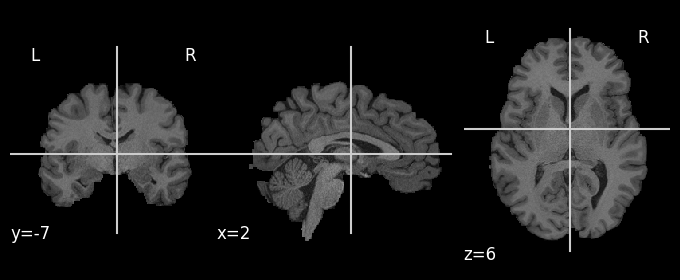

In [7]:
img = nilearn.image.load_img('100408.nii')
plotting.plot_anat(img)

Questions:
1. What is the size of image (file)?
2. That is the intensity distribution of voxels?

In [8]:
img_array = nilearn.image.get_data(img)
img_array.shape

(260, 311, 260)

#### 2. Defining training and target samples

In [9]:
X, y = np.load('tensors.npy'), \
np.load(data_dir + 'labels.npy')
X = X[:, np.newaxis, :, :, :]
print(X.shape, y.shape)

(1113, 1, 58, 70, 58) (1113,)


In [10]:
sample_data = X[1,0,:,:,:]
X[1,0,:,:,:].shape

(58, 70, 58)

**From the sourse article:**

[The original data were too large](https://www.frontiersin.org/articles/10.3389/fnins.2019.00185/full) to train the model and it would cause RESOURCE EXAUSTED problem while training due to the insufficient of GPU memory. The GPU we used in the experiment is NVIDIAN TITAN_XP with 12G memory each. To solve the problem, we scaled the size of FA image to [58 × 70 × 58]. This procedure may lead to a better classification result, since a smaller size of the input image can provide a larger receptive field to the CNN model. In order to perform the image scaling, “dipy” (http://nipy.org/dipy/) was used to read the .nii data of FA. Then “ndimage” in the SciPy (http://www.scipy.org) was used to reduce the size of the data.

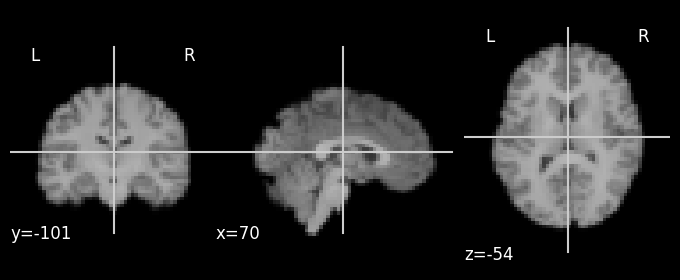

In [11]:
sample_img = nilearn.image.new_img_like(img, sample_data)
plotting.plot_anat(sample_img)


#### 3. Defining Data Set

In [12]:
class MriData(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(MriData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y).long()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

#### 4. Defining the CNN model architecture

[3D PCNN architecture](https://www.frontiersin.org/articles/10.3389/fnins.2019.00185/full)
![model](https://www.frontiersin.org/files/Articles/442577/fnins-13-00185-HTML/image_m/fnins-13-00185-g001.jpg)

At first check if we have GPU onborad:

In [13]:
 torch.cuda.is_available()

True

In [14]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [15]:
## Hidden layers 1, 2 and 3
hidden = lambda c_in, c_out: nn.Sequential(
    nn.Conv3d(c_in, c_out, (3,3,3)), # Convolutional layer
    nn.BatchNorm3d(c_out), # Batch Normalization layer
    nn.ReLU(), # Activational layer
    nn.MaxPool3d(2) # Pooling layer
)

class MriNet(nn.Module):
    def __init__(self, c):
        super(MriNet, self).__init__()
        self.hidden1 = hidden(1, c)
        self.hidden2 = hidden(c, 2*c)
        self.hidden3 = hidden(2*c, 4*c)
        self.linear = nn.Linear(128*5*7*5, 2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = F.log_softmax(x, dim=1)
        return x

torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNet(c).to(device)
summary(model, (1, 58, 70, 58))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 56, 68, 56]             896
       BatchNorm3d-2       [-1, 32, 56, 68, 56]              64
              ReLU-3       [-1, 32, 56, 68, 56]               0
         MaxPool3d-4       [-1, 32, 28, 34, 28]               0
            Conv3d-5       [-1, 64, 26, 32, 26]          55,360
       BatchNorm3d-6       [-1, 64, 26, 32, 26]             128
              ReLU-7       [-1, 64, 26, 32, 26]               0
         MaxPool3d-8       [-1, 64, 13, 16, 13]               0
            Conv3d-9      [-1, 128, 11, 14, 11]         221,312
      BatchNorm3d-10      [-1, 128, 11, 14, 11]             256
             ReLU-11      [-1, 128, 11, 14, 11]               0
        MaxPool3d-12         [-1, 128, 5, 7, 5]               0
          Flatten-13                [-1, 22400]               0
           Linear-14                   

#### 5. Training the model

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#del X, y #deleting for freeing space on disc

train_dataset = MriData(X_train, y_train)
test_dataset = MriData(X_test, y_test)
#del X_train, X_test, y_train, y_test #deleting for freeing space on disc

In [17]:
train_dataset = MriData(X_train, y_train)
test_dataset = MriData(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=45, shuffle=True)  #45 - recommended value for batchsize
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=28, shuffle=False)

In [18]:
CHECKPOINTS_DIR =  data_dir +'/checkpoints'

criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

In [19]:
# timing
from tqdm import tqdm

def get_accuracy(net, data_loader):
    net.eval()
    correct = 0
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        del data, target
    accuracy = 100. * correct / len(data_loader.dataset)
    return accuracy.item()

def get_loss(net, data_loader):
    net.eval()
    loss = 0
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        loss += criterion(out, target).item()*len(data)

        del data, target, out

    return loss / len(data_loader.dataset)


def train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler=None, verbose=True, save=False):
    best_val_loss = 100_000
    best_model = None
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    train_loss_list.append(get_loss(net, train_loader))
    val_loss_list.append(get_loss(net, val_loader))
    train_acc_list.append(get_accuracy(net, train_loader))
    val_acc_list.append(get_accuracy(net, val_loader))
    if verbose:
        print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(0, epochs, train_loss_list[-1], val_loss_list[-1]))

    net.to(device)
    for epoch in tqdm(range(1, epochs+1)):
        net.train()
        for X, y in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = net(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            del X, y, out, loss #freeing gpu space


        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        net.eval()
        for X, y in val_loader:
            # Compute the validation loss
            X, y = X.to(device), y.to(device)
            out = net(X)
            del X, y, out #freeing gpu space

        if scheduler is not None:
            scheduler.step()


        train_loss_list.append(get_loss(net, train_loader))
        val_loss_list.append(get_loss(net, val_loader))
        train_acc_list.append(get_accuracy(net, train_loader))
        val_acc_list.append(get_accuracy(net, val_loader))

        if save and val_loss_list[-1] < best_val_loss:
            torch.save(net.state_dict(), CHECKPOINTS_DIR+'best_model')
        freq = 1
        if verbose and epoch%freq==0:
            print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, train_loss_list[-1], val_loss_list[-1]))

    return train_loss_list, val_loss_list, train_acc_list, val_acc_list

##### Training first **20 epochs**:


In [24]:
# training will take ~8 min
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 20

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=False)

Epoch 00/20 || Loss:  Train 45.8454 | Validation 45.9936


  5%|▌         | 1/20 [00:13<04:22, 13.83s/it]

Epoch 01/20 || Loss:  Train 1.7196 | Validation 1.9023


 10%|█         | 2/20 [00:27<04:02, 13.48s/it]

Epoch 02/20 || Loss:  Train 0.3202 | Validation 0.3874


 15%|█▌        | 3/20 [00:40<03:47, 13.36s/it]

Epoch 03/20 || Loss:  Train 0.3111 | Validation 0.3991


 20%|██        | 4/20 [00:53<03:34, 13.40s/it]

Epoch 04/20 || Loss:  Train 0.2400 | Validation 0.2901


 25%|██▌       | 5/20 [01:07<03:21, 13.46s/it]

Epoch 05/20 || Loss:  Train 0.2225 | Validation 0.2904


 30%|███       | 6/20 [01:21<03:09, 13.56s/it]

Epoch 06/20 || Loss:  Train 0.2191 | Validation 0.2850


 35%|███▌      | 7/20 [01:34<02:56, 13.54s/it]

Epoch 07/20 || Loss:  Train 0.2182 | Validation 0.2873


 40%|████      | 8/20 [01:47<02:42, 13.50s/it]

Epoch 08/20 || Loss:  Train 0.2156 | Validation 0.2821


 45%|████▌     | 9/20 [02:01<02:28, 13.48s/it]

Epoch 09/20 || Loss:  Train 0.2173 | Validation 0.2912


 50%|█████     | 10/20 [02:14<02:14, 13.45s/it]

Epoch 10/20 || Loss:  Train 0.2209 | Validation 0.2996


 55%|█████▌    | 11/20 [02:28<02:00, 13.43s/it]

Epoch 11/20 || Loss:  Train 0.2110 | Validation 0.2824


 60%|██████    | 12/20 [02:41<01:47, 13.44s/it]

Epoch 12/20 || Loss:  Train 0.2085 | Validation 0.2780


 65%|██████▌   | 13/20 [02:55<01:34, 13.44s/it]

Epoch 13/20 || Loss:  Train 0.2077 | Validation 0.2751


 70%|███████   | 14/20 [03:08<01:21, 13.52s/it]

Epoch 14/20 || Loss:  Train 0.2084 | Validation 0.2752


 75%|███████▌  | 15/20 [03:22<01:07, 13.55s/it]

Epoch 15/20 || Loss:  Train 0.2062 | Validation 0.2736


 80%|████████  | 16/20 [03:35<00:54, 13.53s/it]

Epoch 16/20 || Loss:  Train 0.2023 | Validation 0.2735


 85%|████████▌ | 17/20 [03:49<00:40, 13.50s/it]

Epoch 17/20 || Loss:  Train 0.2020 | Validation 0.2751


 90%|█████████ | 18/20 [04:02<00:26, 13.48s/it]

Epoch 18/20 || Loss:  Train 0.2018 | Validation 0.2753


 95%|█████████▌| 19/20 [04:16<00:13, 13.47s/it]

Epoch 19/20 || Loss:  Train 0.2015 | Validation 0.2737


100%|██████████| 20/20 [04:30<00:00, 13.51s/it]

Epoch 20/20 || Loss:  Train 0.2013 | Validation 0.2747


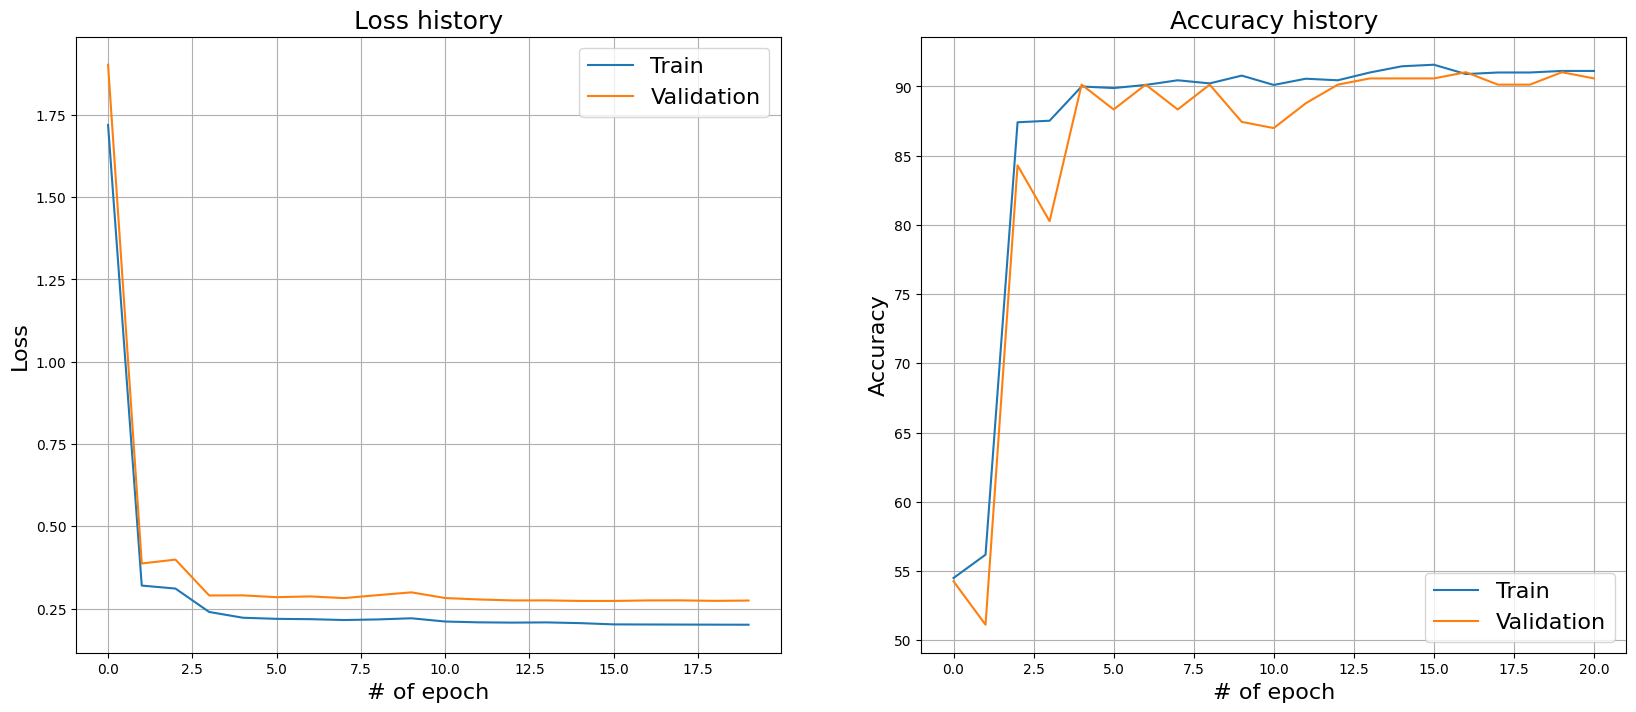

In [25]:
plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
plt.title('Loss history', fontsize=18)
plt.plot(train_loss_list[1:], label='Train')
plt.plot(val_loss_list[1:], label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Accuracy history', fontsize=18)
plt.plot(train_acc_list, label='Train')
plt.plot(val_acc_list, label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=16)
plt.grid()

##### K-Fold model validation:

Questions:
1. What is the purpose of K-Fold in that experiment setting?
2. Can we afford cross-validation in regular DL?

In [20]:
# execute for ~ 23 min
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cross_vall_acc_list = []
j = 0

for train_index, test_index in skf.split(X, y):
    print('Doing {} split'.format(j))
    j += 1

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_dataset = MriData(X_train, y_train)
    test_dataset = MriData(X_test, y_test)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=45, shuffle=True)  #45 - recommended value for batchsize
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=28, shuffle=False)

    torch.manual_seed(1)
    np.random.seed(1)

    c = 32
    model = MriNet(c).to(device)
    criterion = nn.NLLLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

    EPOCHS = 5
    train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=False, verbose=False)
    cross_vall_acc_list.append(get_accuracy(model, val_loader))


Doing 0 split


100%|██████████| 5/5 [01:03<00:00, 12.67s/it]


Doing 1 split


100%|██████████| 5/5 [01:04<00:00, 12.85s/it]


Doing 2 split


100%|██████████| 5/5 [01:04<00:00, 12.95s/it]


In [21]:
print('Average cross-validation accuracy (3-folds):', sum(cross_vall_acc_list)/len(cross_vall_acc_list))

Average cross-validation accuracy (3-folds): 88.67924245198567


In [22]:
cross_vall_acc_list

[86.79244995117188, 88.1401596069336, 91.10511779785156]

#### Model save


In [ ]:
# Training model on whole data and saving it
dataset = MriData(X, y)
loader = torch.utils.data.DataLoader(dataset, batch_size=45, shuffle=True)  #45 - recommended value for batchsize

torch.manual_seed(1)
np.random.seed(1)

model = MriNet(c).to(device)
criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

train(EPOCHS, model, criterion, optimizer, loader, loader, scheduler=scheduler, save=True, verbose=False)
pass

## What else?

MRI classifcation model interpretation

Visit: https://github.com/kondratevakate/InterpretableNeuroDL

Meaningfull perturbations on MEN brains prediction:

![img](https://github.com/kondratevakate/InterpretableNeuroDL/blob/master/image/grad_cam.png?raw=true)